###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2021 Semester 1

## Assignment 1: Pose classification with naive Bayes

###### Submission deadline: 7 pm, Tuesday 6 Apr 2021

**Student ID(s):**     1080613


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [134]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from scipy import stats
from copy import copy

%matplotlib inline

# The body parts corresponding to each of the 11 numbered coordinates.
body_labels = {1: 'head', 2: 'chest', 3: 'r_elbow', 
               4: 'r_hand', 5: 'l_elbow', 6: 'l_hand',
               7: 'hips', 8: 'r_knee', 9: 'r_foot',
               10: 'l_knee', 11: 'l_foot'}

# A list of the possible yoga poses
poses = ['bridge', 'childs', 'downwarddog', 'mountain', 'plank',
         'seatedforwardbend', 'tree', 'trianglepose', 'warrior1', 'warrior2']

In [135]:
def preprocess(train_file_path, test_file_path):

    dataframes = []
    # This funky list comprehension zips together the corresponding coordinates (1, 12), (2, 13),..., 
    # then unpacks the tuples returned from the zip into one list. nice
    col_order = [j for i in zip(range(1, 12), range(12, 23)) for j in i]
    
    for file_path in train_file_path, test_file_path:
        # Load the data from the CSV files using the first column as an index. Consider 9999 to be an NA value.
        data = pd.read_csv(file_path, header=None, index_col=0, na_values=9999)

        # Drop rows that contain only (all) NA values, for some reason there are 15 of these in the training set.
        data.dropna(how='all', inplace=True)

        # Rearrange the columns so that corresponding X and Y coordinates are adjacent.
        data = data[col_order]

        # Create a MultiIndex to easily identify our coordinates and body parts
        index = pd.MultiIndex.from_product((body_labels.values(), ('x', 'y')), names=['Body Part', 'Axis'])
        data.columns = index
        data.index.name = 'pose'

        dataframes.append(data)

    return dataframes

In [136]:
def visualise(data):
    """Generates a 2x11 array of histograms to visualise the distribution of coordinates for each
    body part along each axis."""
    fig, axs = plt.subplots(ncols=11, nrows=2, figsize=(50,8))
    for i, body_part in body_labels.items():
        sns.histplot(data[body_part]['x'], kde=True, ax=axs[0, i-1]).set_title(body_part)
        sns.histplot(data[body_part]['y'], kde=True, ax=axs[1, i-1])
    
    fig.show()


In [137]:
prior = [(1/11)] * 11
prior

[0.09090909090909091,
 0.09090909090909091,
 0.09090909090909091,
 0.09090909090909091,
 0.09090909090909091,
 0.09090909090909091,
 0.09090909090909091,
 0.09090909090909091,
 0.09090909090909091,
 0.09090909090909091,
 0.09090909090909091]

In [138]:
def train(train_data):
    # Using a uniform prior, seems reasonable that all poses are equally likely
    prior = {k: 0.1 for k in poses}

    # Since we setup a multiindex on the dataframes this works well and can be indexed as means['head']['x'] etc.
    means = train_data.groupby(['pose']).mean()
    st_devs = train_data.groupby(['pose']).std()

    return prior, means, st_devs


In [139]:
def predict(test_data, prior, means, st_devs, epsilon=0.001):
    # Extract and remove the ground truth labels
    true_labels = list(test_data.index)
    unlabelled_test_data = test_data.reset_index(drop=True)

    predictions = []

    # We iterate over each instance of the test set
    for number, instance in unlabelled_test_data.iterrows():
        # And set the prior probabilities as calculated in train()
        likelihoods = copy(prior)

        # Now we iterate over all of the possible poses and update the posterior probabilities
        for pose in likelihoods:
            # We use the log likelihood as recommended to avoid rounding of tiny floats
            likelihoods[pose] = math.log(likelihoods[pose])

            # For each of the non-null datapoints we increase the posterior probability by the log of the
            # conditional probability of making said observation given the class label equals pose
            for (body_part, axis), value in instance.dropna().iteritems():
                # We get the PDF of the class conditional on the pose by taking the corresponding μ and σ
                mean = means[body_part][axis][pose]
                sd = st_devs[body_part][axis][pose]

                # We need to add a small epsilon before taking the log likelihood since some tiny
                # probabilities are rounded to 0 from floating point precision.
                likelihoods[pose] += math.log(stats.norm.pdf(value, loc=mean, scale=sd) + epsilon)
        
        # Here setting the key of max to the dictionary's get method makes it return the dictionary
        # key which "gets" (corresponds to) the largest value (this is the arg max function.)
        predictions.append(max(likelihoods, key=likelihoods.get))

    return predictions, true_labels

In [149]:
# This function should evaliate the prediction performance by comparing your model’s class outputs to ground
# truth labels

def evaluate(predictions, true_labels):
    assessment = [i == j for i, j in zip(predictions, true_labels)]
    accuracy = assessment.count(True) / len(assessment)
    
    print(f'Accuracy: {accuracy:0.3f}')



## Entrypoint

In [151]:
# Process the training and testing data into dataframes
train_data, test_data = preprocess("data/train.csv", "data/test.csv")

<ipython-input-136-4de99e0d1dda>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


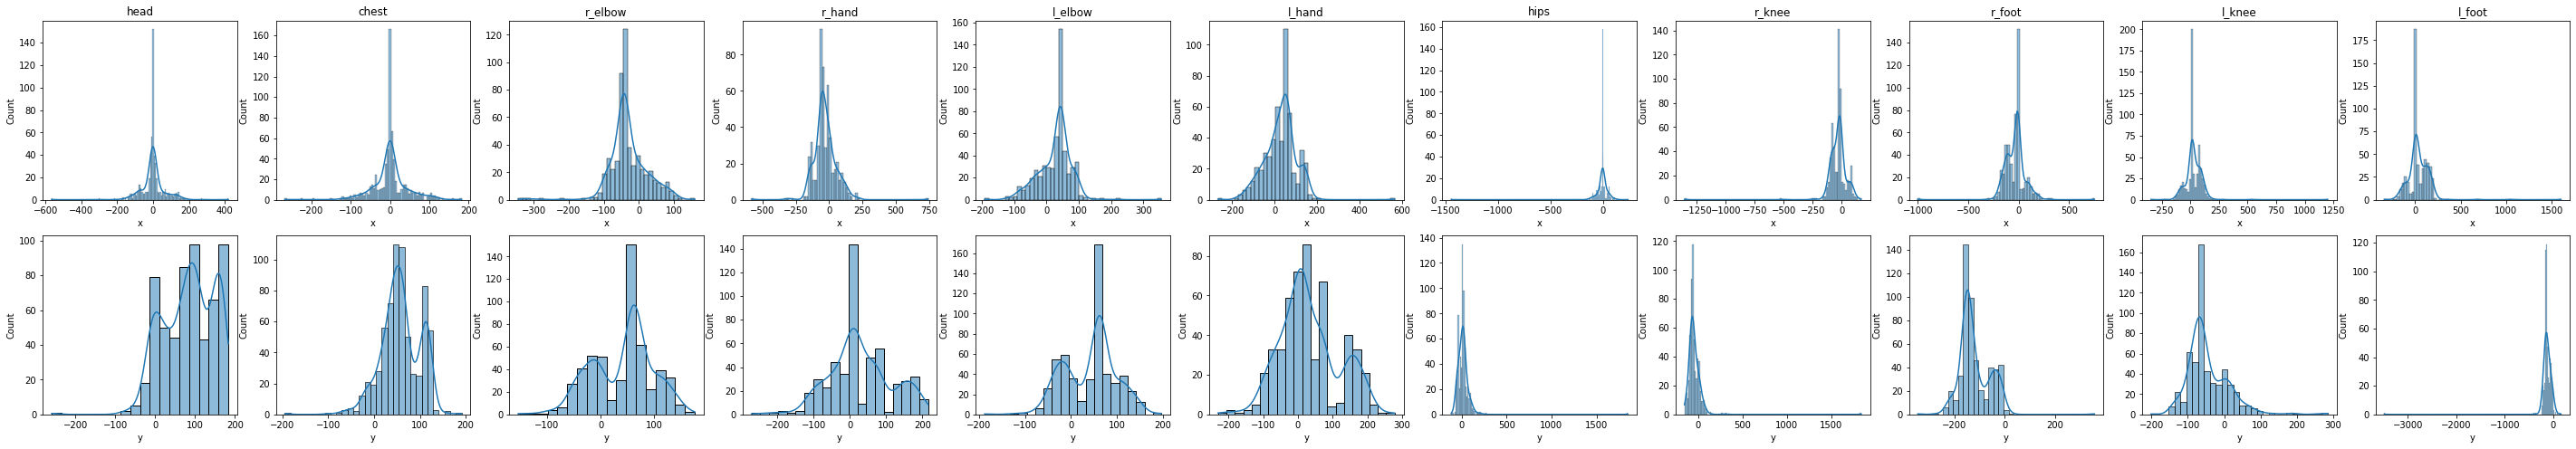

In [152]:
# Visualise the data to verify that the normality assumption is reasonable
visualise(train_data)

In [154]:
# Calculate the prior probabilities and parameters of the conditional distributions
prior, means, st_devs = train(train_data)

In [155]:
# Run the model on the test data
predictions, true_labels = predict(test_data, prior, means, st_devs)

In [156]:
# Evaluate the model by checking the accuracy, precision, and recall
evaluate(predictions, true_labels)

Accuracy: 0.670


## Questions 


If you are in a group of 1, you will respond to **two** questions of your choosing.

If you are in a group of 2, you will respond to **four** questions of your choosing.

A response to a question should take about 100–250 words, and make reference to the data wherever possible.

#### NOTE: you may develop codes or functions to help respond to the question here, but your formal answer should be submitted separately as a PDF.

### Q1
Since this is a multiclass classification problem, there are multiple ways to compute precision, recall, and F-score for this classifier. Implement at least two of the methods from the "Model Evaluation" lecture and discuss any differences between them. (The implementation should be your own and should not just call a pre-existing function.)

### Q2
The Gaussian naıve Bayes classifier assumes that numeric attributes come from a Gaussian distribution. Is this assumption always true for the numeric attributes in this dataset? Identify some cases where the Gaussian assumption is violated and describe any evidence (or lack thereof) that this has some effect on the classifier’s predictions.

### Q3
Implement a kernel density estimate (KDE) naive Bayes classifier and compare its performance to the Gaussian naive Bayes classifier. Recall that KDE has kernel bandwidth as a free parameter -- you can choose an arbitrary value for this, but a value in the range 5-25 is recommended. Discuss any differences you observe between the Gaussian and KDE naive Bayes classifiers. (As with the Gaussian naive Bayes, this KDE naive Bayes implementation should be your own and should not just call a pre-existing function.)

### Q4
Instead of using an arbitrary kernel bandwidth for the KDE naive Bayes classifier, use random hold-out or cross-validation to choose the kernel bandwidth. Discuss how this changes the model performance compared to using an arbitrary kernel bandwidth.

### Q5
Naive Bayes ignores missing values, but in pose recognition tasks the missing values can be informative. Missing values indicate that some part of the body was obscured and sometimes this is relevant to the pose (e.g., holding one hand behind the back). Are missing values useful for this task? Implement a method that incorporates information about missing values and demonstrate whether it changes the classification results.

### Q6
Engineer your own pose features from the provided keypoints. Instead of using the (x,y) positions of keypoints, you might consider the angles of the limbs or body, or the distances between pairs of keypoints. How does a naive Bayes classifier based on your engineered features compare to the classifier using (x,y) values? Please note that we are interested in explainable features for pose recognition, so simply putting the (x,y) values in a neural network or similar to get an arbitrary embedding will not receive full credit for this question. You should be able to explain the rationale behind your proposed features. Also, don't forget the conditional independence assumption of naive Bayes when proposing new features -- a large set of highly-correlated features may not work well.